In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Charger les données ===
data = np.load("training_data.npz", allow_pickle=True)
X = np.array(data["data"], dtype=np.float32)  # conversion importante !
feature_labels = data["feature_labels"]

# Charger les labels
y = pd.read_csv("training_labels.csv")
y = y.iloc[:, 0].values 

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Assume X is your raw input of shape (n_samples, 12, 77)
'''
# Step 1: Mean Imputation per feature
X_imputed = X.copy()
for f in range(X.shape[2]):
    feature_vals = X[:, :, f]
    feature_mean = np.nanmedian(feature_vals)
    X_imputed[:, :, f] = np.nan_to_num(feature_vals, nan=feature_mean)
'''
import numpy as np
from scipy.interpolate import interp1d

def adaptive_interpolate(X):
    """
    Interpolates missing values in a 3D array X of shape (n_samples, time_steps, n_features),
    using an adaptive method depending on how many valid (non-NaN) points there are per sequence.

    - 0 valid points → fill with global mean
    - 1 point        → fill with that single value
    - 2 points       → linear interpolation
    - 3+ points      → cubic interpolation
    """
    n, t, f = X.shape
    X_filled = np.empty_like(X)
    
    # Fallback: global means for each feature
    global_means = np.nanmean(X, axis=(0, 1))  # shape (f,)

    for sample_idx in range(n):
        for feature_idx in range(f):
            ts = X[sample_idx, :, feature_idx]  # time series
            valid_mask = ~np.isnan(ts)
            valid_times = np.where(valid_mask)[0]
            valid_values = ts[valid_mask]
            
            if len(valid_values) == 0:
                X_filled[sample_idx, :, feature_idx] = global_means[feature_idx]
            elif len(valid_values) == 1:
                X_filled[sample_idx, :, feature_idx] = valid_values[0]
            elif len(valid_values) == 2:
                f_interp = interp1d(valid_times, valid_values, kind='linear', fill_value="extrapolate")
                X_filled[sample_idx, :, feature_idx] = f_interp(np.arange(t))
            else:
                f_interp = interp1d(valid_times, valid_values, kind='cubic', fill_value="extrapolate")
                X_filled[sample_idx, :, feature_idx] = f_interp(np.arange(t))
    
    return X_filled

X_filled = adaptive_interpolate(X)

# Step 2: Outlier removal (clip to mean ± 5 * std)
X_no_outliers = X_filled.copy()
for f in range(X.shape[2]):
    mean = np.nanmean(X_no_outliers[:, :, f])
    std = np.nanstd(X_no_outliers[:, :, f])
    lower_bound = mean - 5 * std
    upper_bound = mean + 5 * std
    X_no_outliers[:, :, f] = np.clip(X_no_outliers[:, :, f], lower_bound, upper_bound)

# Step 3: Standard Scaling (per feature, over all samples and time)
n, t, f = X_no_outliers.shape
X_flat = X_no_outliers.reshape(-1, f)  # shape (n * t, f)
scaler = StandardScaler()
X_scaled_flat = scaler.fit_transform(X_flat)
X_ready = X_scaled_flat.reshape(n, t, f)  # final shape: (n_samples, 12, 77)


ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0

In [ ]:
from sklearn.model_selection import train_test_split

# y should be a 1D numpy array of 0/1 labels
X_train, X_val, y_train, y_val = train_test_split(
    X_ready, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)


Train shape: (37556, 12, 77)
Val shape: (16096, 12, 77)


In [121]:
from torch.utils.data import Sampler
import random
import numpy as np

class BalancedBatchSampler(Sampler):
    def __init__(self, labels, batch_size):
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.pos_indices = np.where(self.labels == 1)[0].tolist()
        self.neg_indices = np.where(self.labels == 0)[0].tolist()
        self.batch_half = batch_size // 2

    def __iter__(self):
        # Shuffle both positive and negative indices each epoch
        random.shuffle(self.pos_indices)
        random.shuffle(self.neg_indices)

        pos_iter = iter(self.pos_indices)
        neg_iter = iter(self.neg_indices)

        while True:
            try:
                pos_batch = [next(pos_iter) for _ in range(self.batch_half)]
                neg_batch = [next(neg_iter) for _ in range(self.batch_half)]
                batch = pos_batch + neg_batch
                random.shuffle(batch)
                yield batch
            except StopIteration:
                break

    def __len__(self):
        return min(len(self.pos_indices), len(self.neg_indices)) // self.batch_half


In [122]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split



# Custom Dataset class
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        # Assume X and y are NumPy arrays
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = DiabetesDataset(X_train, y_train)
train_sampler = BalancedBatchSampler(y_train, batch_size=64)
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler)

val_dataset = DiabetesDataset(X_val, y_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [123]:
import torch
import torch.nn as nn

class ImprovedLSTM(nn.Module):
    def __init__(self, input_size=77, hidden_size=128, num_layers=2, dropout=0.3, bidirectional=True):
        super(ImprovedLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=bidirectional
        )
        direction_multiplier = 2 if bidirectional else 1
        self.norm = nn.LayerNorm(hidden_size * direction_multiplier)
        self.fc = nn.Linear(hidden_size * direction_multiplier, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        normalized = self.norm(last_output)
        logits = self.fc(normalized)
        return logits.squeeze()


In [124]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probas = torch.sigmoid(inputs)
        pt = probas * targets + (1 - probas) * (1 - targets)
        focal_term = (1 - pt) ** self.gamma
        loss = self.alpha * focal_term * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [125]:
import torch

# Count positives and negatives in training set
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()

# Compute pos_weight: how much more to weigh the positive class
pos_weight_value = n_neg / n_pos
pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32)

print(f"📊 Positive samples: {n_pos}, Negative samples: {n_neg}")
print(f"⚖️ Using pos_weight = {pos_weight.item():.4f}")


📊 Positive samples: 2375, Negative samples: 35181
⚖️ Using pos_weight = 14.8131


# ***LSTM***

In [126]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Loss, Optimizer
model = ImprovedLSTM().to(device)
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)
# Focal Loss instead of BCEWithLogitsLoss
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


def train_model(train_loader, val_loader, y_train):
    model = ImprovedLSTM().to(device)

    # Compute pos_weight for imbalance
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)

    criterion = FocalLoss(alpha=1, gamma=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    def evaluate(model, dataloader):
        model.eval()
        y_true, y_prob = [], []
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                X_batch = X_batch.to(device)
                logits = model(X_batch)
                probs = torch.sigmoid(logits).cpu().numpy()
                y_prob.extend(probs)
                y_true.extend(y_batch.numpy())
        return np.array(y_true), np.array(y_prob)

    best_f1, best_epoch = 0, 0
    for epoch in range(1, 31):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        y_true, y_prob = evaluate(model, val_loader)
        thresholds = np.linspace(0.1, 0.9, 81)
        f1_scores = [f1_score(y_true, y_prob > t) for t in thresholds]
        best_thresh = thresholds[np.argmax(f1_scores)]
        best_epoch_f1 = max(f1_scores)
        acc = accuracy_score(y_true, y_prob > 0.5)
        auc = roc_auc_score(y_true, y_prob)

        if best_epoch_f1 > best_f1:
            best_f1 = best_epoch_f1
            best_epoch = epoch
            torch.save(model.state_dict(), "best_model_lstm.pth")

        scheduler.step(best_epoch_f1)

        print(f"Epoch {epoch:02d} | Loss: {total_loss:.4f} | Acc: {acc:.4f} | F1@best_thresh: {best_epoch_f1:.4f} | AUC: {auc:.4f}")

    print(f"\n✅ Best F1-score: {best_f1:.4f} achieved at epoch {best_epoch}")
    return model, best_thresh
trained_model, threshold = train_model(train_loader, val_loader, y_train)
# ➤ Call it like this:
# trained_model, threshold = train_model(train_loader, val_loader, y_train)


Epoch 01 | Loss: 30.4484 | Acc: 0.9364 | F1@best_thresh: 0.3970 | AUC: 0.8815
Epoch 02 | Loss: 26.1085 | Acc: 0.9365 | F1@best_thresh: 0.4178 | AUC: 0.8912
Epoch 03 | Loss: 24.9691 | Acc: 0.9399 | F1@best_thresh: 0.4434 | AUC: 0.8990
Epoch 04 | Loss: 24.1282 | Acc: 0.9410 | F1@best_thresh: 0.4482 | AUC: 0.9047
Epoch 05 | Loss: 23.6814 | Acc: 0.9406 | F1@best_thresh: 0.4471 | AUC: 0.9025
Epoch 06 | Loss: 23.0627 | Acc: 0.9396 | F1@best_thresh: 0.4358 | AUC: 0.9009
Epoch 07 | Loss: 22.5571 | Acc: 0.9402 | F1@best_thresh: 0.4457 | AUC: 0.8981
Epoch 08 | Loss: 21.9607 | Acc: 0.9345 | F1@best_thresh: 0.4246 | AUC: 0.8907
Epoch 09 | Loss: 20.6996 | Acc: 0.9400 | F1@best_thresh: 0.4621 | AUC: 0.8986
Epoch 10 | Loss: 20.1351 | Acc: 0.9408 | F1@best_thresh: 0.4502 | AUC: 0.8942
Epoch 11 | Loss: 19.7469 | Acc: 0.9409 | F1@best_thresh: 0.4594 | AUC: 0.8922
Epoch 12 | Loss: 19.4916 | Acc: 0.9397 | F1@best_thresh: 0.4593 | AUC: 0.8864
Epoch 13 | Loss: 19.0524 | Acc: 0.9393 | F1@best_thresh: 0.4589 

# ***CNN***

In [127]:
import torch
import torch.nn as nn

class ImprovedCNNModel(nn.Module):
    def __init__(self, input_channels=77, kernel_size=3, dropout=0.3):
        super(ImprovedCNNModel, self).__init__()

        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.pool = nn.AdaptiveAvgPool1d(1)  # Global Average Pooling
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        # Input shape: (batch, seq_len=12, features=77) → (batch, features, seq_len)
        x = x.permute(0, 2, 1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x).squeeze(-1)  # Shape: (batch, 128)
        x = self.dropout(x)
        x = self.fc(x)
        return x.squeeze()  # Output: (batch,)


In [128]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)
# Focal Loss instead of BCEWithLogitsLoss
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make sure your model and FocalLoss are defined elsewhere
# class DeepCNN(nn.Module): ...
# class FocalLoss(nn.Module): ...

def train_model(train_loader, val_loader, y_train):
    model = ImprovedCNNModel().to(device)

    # Compute pos_weight for imbalance
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)

    criterion = FocalLoss(alpha=1, gamma=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    def evaluate(model, dataloader):
        model.eval()
        y_true, y_prob = [], []
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                X_batch = X_batch.to(device)
                logits = model(X_batch)
                probs = torch.sigmoid(logits).cpu().numpy()
                y_prob.extend(probs)
                y_true.extend(y_batch.numpy())
        return np.array(y_true), np.array(y_prob)

    best_f1, best_epoch = 0, 0
    for epoch in range(1, 31):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        y_true, y_prob = evaluate(model, val_loader)
        thresholds = np.linspace(0.1, 0.9, 81)
        f1_scores = [f1_score(y_true, y_prob > t) for t in thresholds]
        best_thresh = thresholds[np.argmax(f1_scores)]
        best_epoch_f1 = max(f1_scores)
        acc = accuracy_score(y_true, y_prob > 0.5)
        auc = roc_auc_score(y_true, y_prob)

        if best_epoch_f1 > best_f1:
            best_f1 = best_epoch_f1
            best_epoch = epoch
            torch.save(model.state_dict(), "best_model_cnn.pth")

        scheduler.step(best_epoch_f1)

        print(f"Epoch {epoch:02d} | Loss: {total_loss:.4f} | Acc: {acc:.4f} | F1@best_thresh: {best_epoch_f1:.4f} | AUC: {auc:.4f}")

    print(f"\n✅ Best F1-score: {best_f1:.4f} achieved at epoch {best_epoch}")
    return model, best_thresh
trained_model, threshold = train_model(train_loader, val_loader, y_train)
# ➤ Call it like this:
# trained_model, threshold = train_model(train_loader, val_loader, y_train)


Epoch 01 | Loss: 31.8442 | Acc: 0.9386 | F1@best_thresh: 0.3883 | AUC: 0.8825
Epoch 02 | Loss: 27.5463 | Acc: 0.9392 | F1@best_thresh: 0.3990 | AUC: 0.8887
Epoch 03 | Loss: 26.3977 | Acc: 0.9380 | F1@best_thresh: 0.4183 | AUC: 0.8928
Epoch 04 | Loss: 25.5559 | Acc: 0.9394 | F1@best_thresh: 0.4133 | AUC: 0.8920
Epoch 05 | Loss: 25.0849 | Acc: 0.9396 | F1@best_thresh: 0.4352 | AUC: 0.8963
Epoch 06 | Loss: 24.8954 | Acc: 0.9391 | F1@best_thresh: 0.4123 | AUC: 0.8931
Epoch 07 | Loss: 24.3378 | Acc: 0.9404 | F1@best_thresh: 0.4340 | AUC: 0.8992
Epoch 08 | Loss: 24.2240 | Acc: 0.9409 | F1@best_thresh: 0.4223 | AUC: 0.8950
Epoch 09 | Loss: 23.8462 | Acc: 0.9394 | F1@best_thresh: 0.4352 | AUC: 0.9005
Epoch 10 | Loss: 22.7405 | Acc: 0.9407 | F1@best_thresh: 0.4343 | AUC: 0.9016
Epoch 11 | Loss: 22.5443 | Acc: 0.9404 | F1@best_thresh: 0.4385 | AUC: 0.9001
Epoch 12 | Loss: 22.2127 | Acc: 0.9400 | F1@best_thresh: 0.4354 | AUC: 0.8998
Epoch 13 | Loss: 22.1730 | Acc: 0.9402 | F1@best_thresh: 0.4497 

# ***transformer***

In [131]:
import torch
import torch.nn as nn
import math

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size=308, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()

        self.input_projection = nn.Linear(input_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout, max_len=100)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        x = self.input_projection(x)  # (batch, seq_len, d_model)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]  # use the last time step's representation
        x = self.norm(x)
        return self.head(x).squeeze()

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


In [132]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── Focal Loss (assuming it's already defined) ─────────────────────────────
# class FocalLoss(nn.Module): ...

# ─── Transformer model (you already defined it) ─────────────────────────────
# class TimeSeriesTransformer(nn.Module): ...

def train_transformer_model(train_loader, val_loader, y_train):
    model = TimeSeriesTransformer(input_size=77).to(device)  # ← change input_size if needed

    # Class imbalance handling
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)

    criterion = FocalLoss(alpha=1, gamma=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    def evaluate(model, dataloader):
        model.eval()
        y_true, y_prob = [], []
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                X_batch = X_batch.to(device)
                logits = model(X_batch)
                probs = torch.sigmoid(logits).cpu().numpy()
                y_prob.extend(probs)
                y_true.extend(y_batch.numpy())
        return np.array(y_true), np.array(y_prob)

    best_f1, best_epoch = 0, 0
    for epoch in range(1, 31):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        y_true, y_prob = evaluate(model, val_loader)
        thresholds = np.linspace(0.1, 0.9, 81)
        f1_scores = [f1_score(y_true, y_prob > t) for t in thresholds]
        best_thresh = thresholds[np.argmax(f1_scores)]
        best_epoch_f1 = max(f1_scores)
        acc = accuracy_score(y_true, y_prob > 0.5)
        auc = roc_auc_score(y_true, y_prob)

        if best_epoch_f1 > best_f1:
            best_f1 = best_epoch_f1
            best_epoch = epoch
            torch.save(model.state_dict(), "best_model_transformer.pth")

        scheduler.step(best_epoch_f1)

        print(f"Epoch {epoch:02d} | Loss: {total_loss:.4f} | Acc: {acc:.4f} | F1@best_thresh: {best_epoch_f1:.4f} | AUC: {auc:.4f}")

    print(f"\n✅ Best F1-score: {best_f1:.4f} achieved at epoch {best_epoch}")
    return model, best_thresh

trained_model, threshold = train_transformer_model(train_loader, val_loader, y_train)


Epoch 01 | Loss: 32.1412 | Acc: 0.9368 | F1@best_thresh: 0.3737 | AUC: 0.8796
Epoch 02 | Loss: 28.6734 | Acc: 0.9368 | F1@best_thresh: 0.4092 | AUC: 0.8833
Epoch 03 | Loss: 30.1247 | Acc: 0.9368 | F1@best_thresh: 0.3297 | AUC: 0.7962
Epoch 04 | Loss: 32.8621 | Acc: 0.9368 | F1@best_thresh: 0.2293 | AUC: 0.7947
Epoch 05 | Loss: 34.2391 | Acc: 0.9368 | F1@best_thresh: 0.1412 | AUC: 0.4851


KeyboardInterrupt: 

# ***fusion***

In [38]:
lstm_model = ImprovedLSTM().to(device)
cnn_model = ImprovedCNNModel().to(device)

lstm_model.load_state_dict(torch.load("best_model_lstm.pth"))
cnn_model.load_state_dict(torch.load("best_model_cnn.pth"))

lstm_model.eval()
cnn_model.eval()


ImprovedCNNModel(
  (conv1): Conv1d(77, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [39]:
def get_model_probs(model, dataloader):
    probs = []
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            prob = torch.sigmoid(logits).cpu().numpy()
            probs.extend(prob)
    return np.array(probs)

y_true = []
for _, y_batch in val_loader:
    y_true.extend(y_batch.numpy())
y_true = np.array(y_true)

probs_lstm = get_model_probs(lstm_model, val_loader)
probs_cnn  = get_model_probs(cnn_model, val_loader)


In [40]:
probs_fused = 0.6 * probs_lstm + 0.4 * probs_cnn


In [52]:
thresholds = np.linspace(0.1, 0.9, 81)
f1s = [f1_score(y_true, probs_fused > t) for t in thresholds]
best_thresh = thresholds[np.argmax(f1s)]

final_f1 = max(f1s)
final_acc = accuracy_score(y_true, probs_fused > 0.5)
final_auc = roc_auc_score(y_true, probs_fused)

print(f"\n📊 Fusion Results:")
print(f"AUC: {final_auc:.4f} | Acc: {final_acc:.4f} | Best F1: {final_f1:.4f} @ Threshold: {best_thresh:.2f}")


ValueError: Found input variables with inconsistent numbers of samples: [10731, 26826]

In [ ]:
y_pred = (probs_fused > best_thresh).astype(int)
errors = (y_pred != y_true).astype(int)  # 1 if misclassified, 0 if correct


# ***meta learner***

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# ─── Load models ────────────────────────────────────────────────────────────
lstm_model = ImprovedLSTM().to(device)
cnn_model = ImprovedCNNModel().to(device)

lstm_model.load_state_dict(torch.load("best_model_lstm.pth"))
cnn_model.load_state_dict(torch.load("best_model_cnn.pth"))

lstm_model.eval()
cnn_model.eval()

# ─── Get model probabilities ────────────────────────────────────────────────
def get_model_probs(model, dataloader):
    probs = []
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            prob = torch.sigmoid(logits).cpu().numpy()
            probs.extend(prob)
    return np.array(probs)

# ─── True labels ────────────────────────────────────────────────────────────
y_true = []
for _, y_batch in val_loader:
    y_true.extend(y_batch.numpy())
y_true = np.array(y_true)

# ─── Probabilities from each model ──────────────────────────────────────────
probs_lstm = get_model_probs(lstm_model, val_loader)
probs_cnn  = get_model_probs(cnn_model, val_loader)

# ─── Train meta-learner on model predictions ────────────────────────────────
X_stack = np.vstack([probs_lstm, probs_cnn]).T  # shape: (n_samples, 2)
meta_model = LogisticRegression()
meta_model.fit(X_stack, y_true)

# ─── Fused probability from meta-learner ────────────────────────────────────
probs_fused = meta_model.predict_proba(X_stack)[:, 1]

# ─── Find best F1 threshold ─────────────────────────────────────────────────
thresholds = np.linspace(0.1, 0.9, 81)
f1s = [f1_score(y_true, probs_fused > t) for t in thresholds]
best_thresh = thresholds[np.argmax(f1s)]

# ─── Final Metrics ──────────────────────────────────────────────────────────
final_f1 = max(f1s)
final_acc = accuracy_score(y_true, probs_fused > 0.5)
final_auc = roc_auc_score(y_true, probs_fused)

print(f"\n📊 Fusion Results (Meta-Learner):")
print(f"AUC: {final_auc:.4f} | Acc: {final_acc:.4f} | Best F1: {final_f1:.4f} @ Threshold: {best_thresh:.2f}")



📊 Fusion Results (Meta + Biological Features):
AUC: 0.9062 | Acc: 0.9419 | Best F1: 0.4829 @ Threshold: 0.23


In [110]:
import joblib
joblib.dump(meta_model, "meta_model.pkl")


['meta_model.pkl']

In [70]:
y_pred = (probs_fused > best_thresh).astype(int)
errors = (y_pred != y_true).astype(int)  # 1 if misclassified, 0 if correct


In [72]:
meta_X = np.mean(X_val, axis=1)  # shape: (n_patients, n_features)

meta_y = errors  # from step above


In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

meta_model = RandomForestClassifier()
meta_model.fit(meta_X, meta_y)

print(classification_report(meta_y, meta_model.predict(meta_X)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9811
           1       0.96      0.97      0.97       920

    accuracy                           0.99     10731
   macro avg       0.98      0.98      0.98     10731
weighted avg       0.99      0.99      0.99     10731



In [74]:
importances = meta_model.feature_importances_


In [75]:
misclassified_idx = np.where(errors == 1)[0]


In [76]:
hard_patients = X_val[misclassified_idx]        # shape: (n_hard, t, f)
hard_labels   = y_true[misclassified_idx]       # true labels
hard_preds    = y_pred[misclassified_idx]       # wrong predictions


In [77]:
print(f"Total hard patients: {len(hard_patients)}")


Total hard patients: 920


In [80]:
import pandas as pd

# Mean feature values over time
hard_means = np.nanmean(hard_patients, axis=1)  # shape: (n_hard, f)
easy_means = np.nanmean(X_val[errors == 0], axis=1)

df_hard = pd.DataFrame(hard_means, columns=[f'F{i}' for i in range(hard_means.shape[1])])
df_easy = pd.DataFrame(easy_means, columns=[f'F{i}' for i in range(easy_means.shape[1])])

# Compare feature-wise averages
diff = df_hard.mean() - df_easy.mean()
top_diff = diff.abs().sort_values(ascending=False).head(20)
print("🔍 Top features that differ between hard and easy patients:\n")
print(top_diff)


🔍 Top features that differ between hard and easy patients:

F41    0.169694
F42    0.129216
F30    0.117308
F51    0.104652
F5     0.098290
F6     0.090720
F55    0.089622
F3     0.087442
F63    0.086043
F66    0.085787
F65    0.085770
F59    0.085769
F52    0.085765
F61    0.085722
F58    0.085450
F60    0.085314
F50    0.085014
F56    0.084907
F68    0.083082
F67    0.082888
dtype: float32


In [82]:
top_feat_ids = top_diff.index.str.extract(r'F(\d+)').astype(int)[0]

for i in top_feat_ids:
    print(f"F{i}: {feature_labels[i]}")


F41: inr
F42: inr_a
F30: hba1c
F51: platelets
F5: ast
F6: alt
F55: lymphocytes
F3: prothrombin_time
F63: hyperbasophilic_lymphocytes
F66: atypical_lymphocytes
F65: villous_lymphocytes
F59: granular_lymphocytes
F52: plasma_cells
F61: hemoglobin
F58: myelocytes
F60: erythroblasts
F50: hematocrit
F56: mchc
F68: mcv
F67: mch


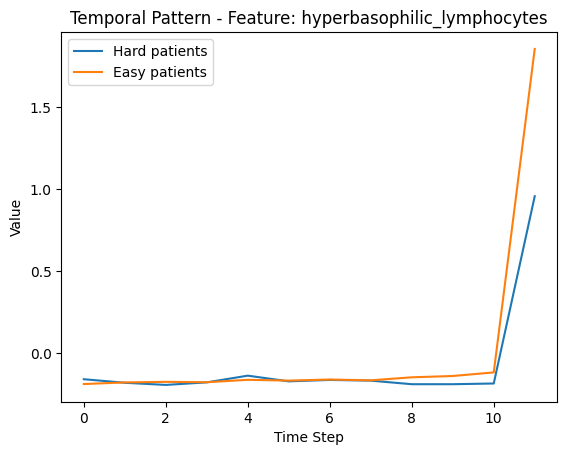

In [91]:
import matplotlib.pyplot as plt

feature_id = 63 # Example, replace with top ones like 41, 42, etc.
hard_mean = np.nanmean(hard_patients[:, :, feature_id], axis=0)
easy_mean = np.nanmean(X_val[errors == 0][:, :, feature_id], axis=0)

plt.plot(hard_mean, label="Hard patients")
plt.plot(easy_mean, label="Easy patients")
plt.title(f"Temporal Pattern - Feature: {feature_labels[feature_id]}")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()


# ***testing***

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# ───────────────────────────────────────────────────────────────
# Load test data
# ───────────────────────────────────────────────────────────────
data = np.load("evaluation_data.npz", allow_pickle=True)
X_test = np.array(data["data"], dtype=np.float32)  # conversion importante !
feature_labels = data["feature_labels"]



# ───────────────────────────────────────────────────────────────
# Apply preprocessing (same as training pipeline)
# ───────────────────────────────────────────────────────────────

X_imputed = X_test.copy()
for f in range(X_test.shape[2]):
    feature_vals = X_test[:, :, f]
    X_imputed[:, :, f] = np.nan_to_num(feature_vals, nan=0.0)

# Step 2: Outlier clipping (mean ± 5*std)
for f in range(X_test.shape[2]):
    mean = np.nanmean(X_test[:, :, f])
    std = np.nanstd(X_test[:, :, f])
    lower = mean - 5 * std
    upper = mean + 5 * std
    X_test[:, :, f] = np.clip(X_test[:, :, f], lower, upper)

# Step 3: Standard Scaling
n, t, f = X_test.shape
X_flat = X_test.reshape(-1, f)
scaler = StandardScaler()
X_scaled_flat = scaler.fit_transform(X_flat)
X_test_ready = X_scaled_flat.reshape(n, t, f)

# ───────────────────────────────────────────────────────────────
# Convert to PyTorch dataloader (no labels here)
# ───────────────────────────────────────────────────────────────
from torch.utils.data import DataLoader, TensorDataset

X_tensor = torch.tensor(X_test_ready, dtype=torch.float32)
dummy_labels = torch.zeros(len(X_tensor))  # dummy placeholder
test_loader = DataLoader(TensorDataset(X_tensor, dummy_labels), batch_size=64, shuffle=False)

# ───────────────────────────────────────────────────────────────
# Load both trained models
# ───────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lstm_model = ImprovedLSTM().to(device)
cnn_model = ImprovedCNNModel().to(device)
lstm_model.load_state_dict(torch.load("best_model_lstm.pth"))
cnn_model.load_state_dict(torch.load("best_model_cnn.pth"))
lstm_model.eval()
cnn_model.eval()

# ───────────────────────────────────────────────────────────────
# Predict probabilities and apply weighted fusion
# ───────────────────────────────────────────────────────────────
def get_model_probs(model, dataloader):
    probs = []
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            prob = torch.sigmoid(logits).cpu().numpy()
            probs.extend(prob)
    return np.array(probs)

probs_lstm = get_model_probs(lstm_model, test_loader)
probs_cnn  = get_model_probs(cnn_model, test_loader)
probs_fused = 0.4 * probs_lstm + 0.6 * probs_cnn

# ───────────────────────────────────────────────────────────────
# Convert probs to class labels using threshold 0.39
# ───────────────────────────────────────────────────────────────
best_thresh = 0.36
labels = (probs_fused > best_thresh).astype(int).flatten()

# ───────────────────────────────────────────────────────────────
# Generate final submission file
# ───────────────────────────────────────────────────────────────
submission = pd.DataFrame({
    "Id": np.arange(len(labels)),
    "Label": labels
})

submission.to_csv("final_submission.csv", index=False)
print("✅ Submission file saved as final_submission.csv with binary labels.")


✅ Submission file saved as final_submission.csv with binary labels.
